In [1]:
import torch
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from dlprog import train_progress

from model import VAE
from train_data import get_dataloader

In [2]:
prog = train_progress()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
data_root = "./data"
image_size = 96
batch_size = 64
split = "unlabeled"
dataloader = get_dataloader(data_root, image_size, batch_size, split)
x, _ = next(iter(dataloader))
x.shape

torch.Size([64, 3, 96, 96])

In [4]:
@torch.no_grad()
def draw(model, n_images=10, width=800):
    model.eval()
    x, _ = next(iter(dataloader))
    x = x[:n_images].to(device)
    y, _, _,  = model(x)
    img = torch.cat([x, y], dim=0).cpu()
    img = transforms.Resize((width // n_images), antialias=True)(img)
    img = torchvision.utils.make_grid(img, nrow=n_images)
    img = transforms.functional.to_pil_image(img)
    display(img)

In [5]:
def loss_fn(x, y, mean, log_var):
    loss_recons = F.binary_cross_entropy(y, x)
    loss_reg = -0.5 * torch.mean(1 + log_var - mean**2 - log_var.exp())
    return loss_recons, loss_reg

def train(
    model: VAE,
    optimizer: optim.Optimizer,
    dataloader: DataLoader,
    beta: float = 1,
    n_epochs: int = 30,
    save_path: str = "./models/vae.pth",
    prog_unit: int = 1,
) -> None:
    prog.start(
        n_epochs=n_epochs,
        n_iter=len(dataloader),
        unit=prog_unit,
        label=["loss recons", "reg"]
    )
    for _ in range(n_epochs):
        model.train()
        for x, _ in dataloader:
            optimizer.zero_grad()
            x = x.to(device)
            y, mean, log_var = model(x)
            loss_recons, loss_reg = loss_fn(x, y, mean, log_var)
            loss = loss_recons + beta * loss_reg
            loss.backward()
            optimizer.step()
            prog.update([loss_recons.item(), loss_reg.item()])
        if (prog.now_epoch - 1) % prog_unit == 0:
            draw(model)
            model.save(save_path)

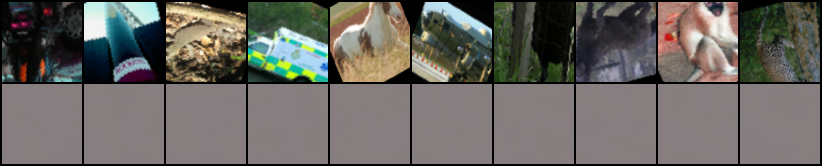

In [6]:
z_dim = 512
lr = 1e-4
model = VAE(z_dim).to(device)
draw(model)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
train(
    model,
    optimizer,
    dataloader,
    beta=0.1,
    save_path="./models/vae3.pth",
    n_epochs=25
)

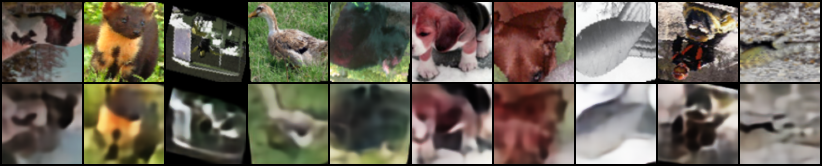

In [47]:
draw(model)